In [1]:
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
training_file = '../traffic-signs-data/train.p'
validation_file= '../traffic-signs-data/valid.p'
testing_file = '../traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

(array([ 180., 1980., 2010., 1260., 1770., 1650.,  360., 1290., 1260.,
        1320., 1800., 1170., 1890., 1920.,  690.,  540.,  360.,  990.,
        1080.,  180.,  300.,  270.,  330.,  450.,  240., 1350.,  540.,
         210.,  480.,  240.,  390.,  690.,  210.,  599.,  360., 1080.,
         330.,  180., 1860.,  270.,  300.,  420.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42], dtype=uint8),
 <a list of 42 Patch objects>)

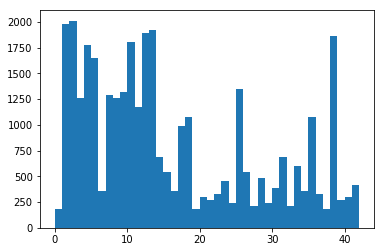

In [3]:
plt.hist(y_train, bins=np.unique(y_train))

In [4]:
# store data in dictionary
data_dict = {i:[] for i in np.unique(y_train)}
for i in range(len(X_train)):
    data_dict[y_train[i]].append(X_train[i])
    

(500, 32, 32, 3) (500,)


(array([ 9., 11.,  9., 13.,  7.,  6., 13., 11., 12., 15., 17., 10., 10.,
        14., 11.,  7., 11., 11., 14., 10., 15., 11., 14., 10.,  5.,  9.,
        14., 16., 14., 11.,  8., 10., 18., 15., 12., 12.,  7., 13., 12.,
        11., 12., 30.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42], dtype=uint8),
 <a list of 42 Patch objects>)

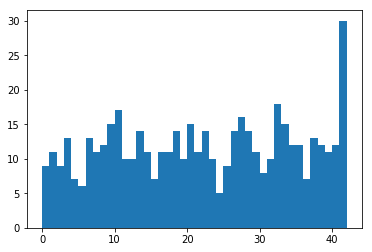

In [5]:
# uniform sampling
import random

batch_size = 500

# sample y
y_out = np.random.choice(np.unique(y_train), size=batch_size)

# sample x
x_out = []
for i, cat in enumerate(y_out):
    x = random.choice(data_dict[cat])
    x_out.append(x)
x_out = np.stack(x_out)

print(x_out.shape, y_out.shape)
plt.hist(y_out, bins=np.unique(y_out))

In [6]:
def data_generator(X, y, size):
    while True:
        # sample y
        y_out = np.random.choice(np.unique(y_train), size=size)

        # sample x
        x_out = []
        for i, cat in enumerate(y_out):
            x = random.choice(data_dict[cat])
            x_out.append(x)
        x_out = np.stack(x_out)

        yield x_out, y_out


(128, 32, 32, 3) (128,)
(128, 32, 32, 3) (128,)
(128, 32, 32, 3) (128,)
(128, 32, 32, 3) (128,)
(128, 32, 32, 3) (128,)


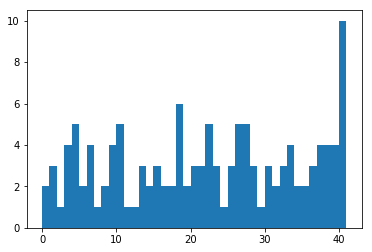

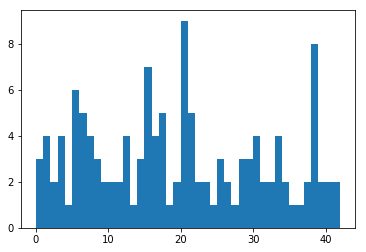

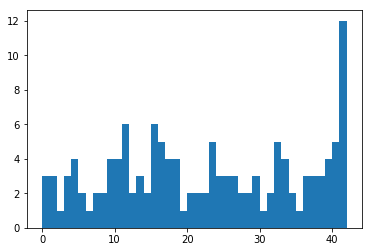

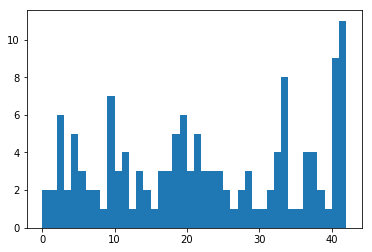

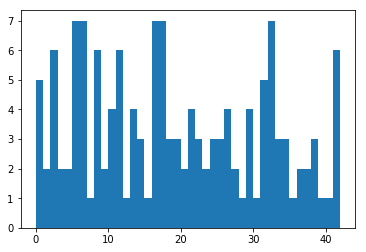

In [7]:
datagen = data_generator(X_train, y_train, size=128)

for _ in range(5):
    x_out, y_out = next(datagen)
    print(x_out.shape, y_out.shape)
    plt.figure()
    plt.hist(y_out, bins=np.unique(y_out))

In [8]:
# from: https://github.com/dingran/traffic-sign-classifier/blob/master/tsc_utils.py

def normalize_img(img):
    '''
    rescale pixel values to -0.5 to 0.5 range
    '''
    # shift center and normalize
    norm = (img.astype(np.float32))/255.0 - 0.5
    return norm

def distort_img(input_img, d_limit=4):
    """
    Apply warpPerspective transformation on image, with 4 key points, randomly generated around the corners
    with uniform distribution with a range of [-d_limit, d_limit]
    :param input_img:
    :param d_limit:
    :return:
    """
    if d_limit == 0:
        return input_img
    rows, cols, ch = input_img.shape
    pts2 = np.float32([[0, 0], [rows - 1, 0], [0, cols - 1], [rows - 1, cols - 1]])
    pts1 = np.float32(pts2 + np.random.uniform(-d_limit, d_limit, pts2.shape))
    M = cv2.getPerspectiveTransform(pts1, pts2)
    dst = cv2.warpPerspective(input_img, M, (cols, rows), borderMode=1)
    return dst


def resize_img(input_img, scale=1.1):
    """
    Function to scale image content while keeping the overall image size, padding is done with border replication
    Scale > 1 means making content bigger
    :param input_img: X * Y * ch
    :param scale: positive real number
    :return: scaled image
    """
    if scale == 1.0:
        return input_img
    rows, cols, ch = input_img.shape
    d = rows * (scale - 1)  # overall image size change from rows, cols, to rows - 2d, cols - 2d
    pts1 = np.float32([[d, d], [rows - 1 - d, d], [d, cols - 1 - d], [rows - 1 - d, cols - 1 - d]])
    pts2 = np.float32([[0, 0], [rows - 1, 0], [0, cols - 1], [rows - 1, cols - 1]])
    M = cv2.getPerspectiveTransform(pts1, pts2)
    dst = cv2.warpPerspective(input_img, M, (cols, rows), borderMode=1)
    return dst


def rotate_img(input_img, angle=15):
    if angle == 0:
        return input_img
    rows, cols, ch = input_img.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    dst = cv2.warpAffine(input_img, M, (cols, rows), borderMode=1)
    return dst


def shift_img(input_img, dx=2, dy=2):
    if dx == 0 and dy == 0:
        return input_img
    M = np.float32([[1, 0, dx], [0, 1, dy]])
    dst = cv2.warpAffine(input_img, M, (input_img.shape[0], input_img.shape[1]), borderMode=1)
    return dst


def blur_or_sharpen_img(input_img, kernel=(3, 3), ratio=0.7, factor=1.0):
    blur = cv2.GaussianBlur(input_img, kernel, 0)
    sharp = cv2.addWeighted(input_img, 1.0 + ratio * factor, blur, -ratio * factor, 0)
    return random.choice([blur, sharp])

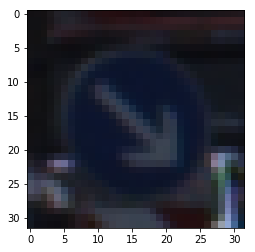

In [9]:
img = X_train[np.random.randint(0, len(X_train))]
plt.imshow(img)

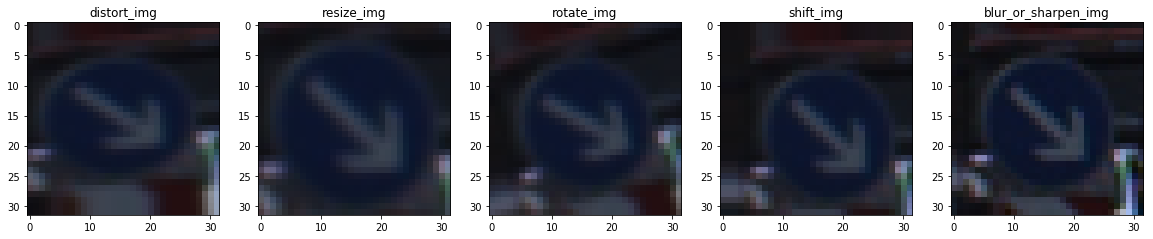

In [10]:
pipeline = [distort_img, 
            resize_img, 
            rotate_img, 
            shift_img,
            blur_or_sharpen_img
           ]

plt.figure(figsize=(20,10))
for i, f in enumerate(pipeline):
    plt.subplot(1, len(pipeline), i+1)
    plt.imshow(f(img))
    plt.title(f.__name__)

In [11]:
pipeline = [distort_img, 
            resize_img, 
            rotate_img, 
            shift_img,
            blur_or_sharpen_img
           ]

def run_pipeline(pipeline, img):
    x = img.copy()
    for f in pipeline:
        try:
            y = f(x)
            x = y
        except:
            print('error with ', f.__name__)
    return y
    

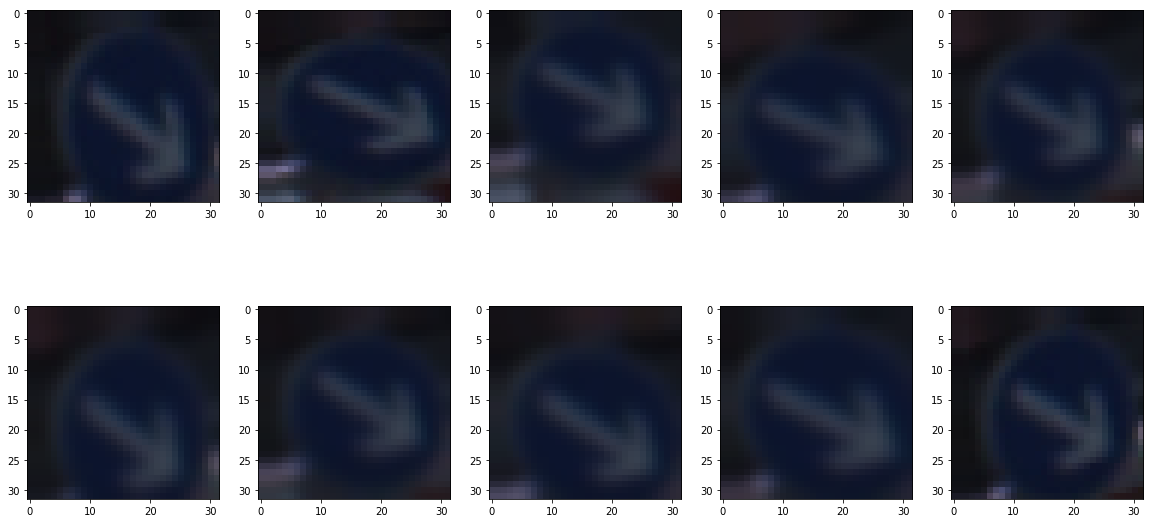

In [12]:
plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(run_pipeline(pipeline, img))
    

In [13]:
X_train2 = np.apply_over_axes(distort_img, X_train, 0)

In [14]:
X_train2.shape

(34799, 32, 32, 3)

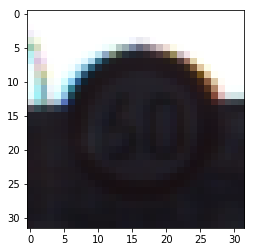

In [15]:
plt.imshow(X_train2[np.random.randint(0, len(X_train2))])

In [16]:
X_train2 = np.apply_over_axes(normalize_img, X_train2, 0)
X_train2.shape

TypeError: normalize_img() takes 1 positional argument but 2 were given

In [16]:
# test code
import util

training_file = '../traffic-signs-data/train.p'
validation_file= '../traffic-signs-data/valid.p'
testing_file = '../traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

(100, 32, 32, 3) (100,)
(100, 32, 32, 3) (100,)
(100, 32, 32, 3) (100,)
(100, 32, 32, 3) (100,)
(100, 32, 32, 3) (100,)


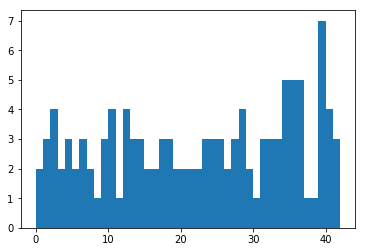

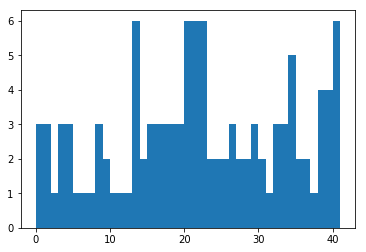

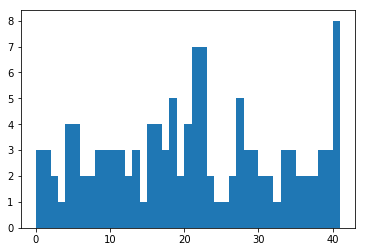

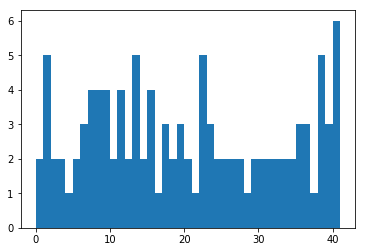

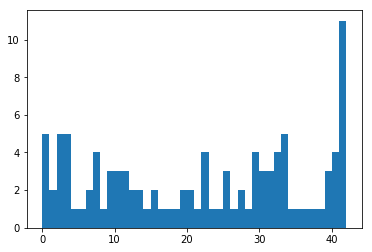

In [17]:
datagen = util.generator(X_train, y_train, 100)

for _ in range(5):
    x_out, y_out = next(datagen)
    print(x_out.shape, y_out.shape)
    plt.figure()
    plt.hist(y_out, bins=np.unique(y_out))

In [18]:
x_out_p = util.preprocess(x_out)

In [20]:
print(x_out_p.shape)


(100, 32, 32, 3)
